# Data Loading/Preprocessing/Visualization

### Loading

In [42]:
import json
import numpy as np

# Load the data from the JSON file
with open('data/data.json') as f:
    data = json.load(f)

# Print the data content of the JSON file
print(f"Data is list of {len(data)} items")
print(f"Each item is a dictionary with keys: {data[0].keys()}")
print(f"The 'sequence' key is a list of {np.array(data[0]['sequence']).shape[0]} elements with 15x15=225 entries each")
print(f"When an items has label '1', the sequence contain at least one elements which has quanching")
print(f"The events with label '1' have also wich step of the sequece has the 'quench' label where it's stored the x,y,t position of the quenching event and the temperature")


Data is list of 3000 items
Each item is a dictionary with keys: dict_keys(['sequence', 'label'])
The 'sequence' key is a list of 24 elements with 15x15=225 entries each
When an items has label '1', the sequence contain at least one elements which has quanching
The events with label '1' have also wich step of the sequece has the 'quench' label where it's stored the x,y,t position of the quenching event and the temperature


### Preprocessing for data visualization

In [43]:
# Let's convert the data to a numpy array
dataPost = np.array([[np.array(item['sequence'][step]).reshape(15, 15) for step in np.arange(0, 24) ] for item in data]) #looping over sequences and reshaping each step of the sequence to 15x15
labels = np.array([item['label'] for item in data]) #looping over sequences and getting the label of each sequence 

# -------- quench label --------
quench = [item["quench"] if item['label'] == 1 else [{'step': -1, 'pixel': [-1, -1], 'temp': -1}] for item in data]
maxNquenches = max([len(item) for item in quench])
print(f"Max number of quenching events in a sequence: {maxNquenches}")
# Now let's modify the quench list in order to have an homogeneous shape for all the sequences
for i in range(len(quench)):
    while len(quench[i]) < maxNquenches:
        quench[i].append({'step': -1, 'pixel': [-1, -1], 'temp': -1})
quench = np.array(quench)
# Now let's convert it in a numpy structured array
dtype = np.dtype([('step', 'i4'), ('pixel_x', 'i4'), ('pixel_y', 'i4'), ('temp', 'f4')])
quenchPost = np.zeros((quench.shape[0], quench.shape[1]), dtype=dtype)

for i in range(quench.shape[0]):
    for j in range(quench.shape[1]):
        quenchPost[i, j] = (
            quench[i][j]['step'],
            quench[i][j]['pixel'][0],
            quench[i][j]['pixel'][1],
            quench[i][j]['temp']
        )
print(f"quenchPost shape: {quenchPost.shape}")
# ------------------------------                       #All this work is to have a more defined structure of the data, so we can use it in the model later on


print(f"quenchPost shape: {quench.shape}") # --> (n_sequences, maxNquenches)
print(f"dataPost shape: {dataPost.shape}") # --> (n_sequences, n_steps, 15, 15)
print(f"labels shape: {labels.shape}") # --> (n_sequences,)

Max number of quenching events in a sequence: 14
quenchPost shape: (3000, 14)
quenchPost shape: (3000, 14)
dataPost shape: (3000, 24, 15, 15)
labels shape: (3000,)


### Visualization

In [44]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

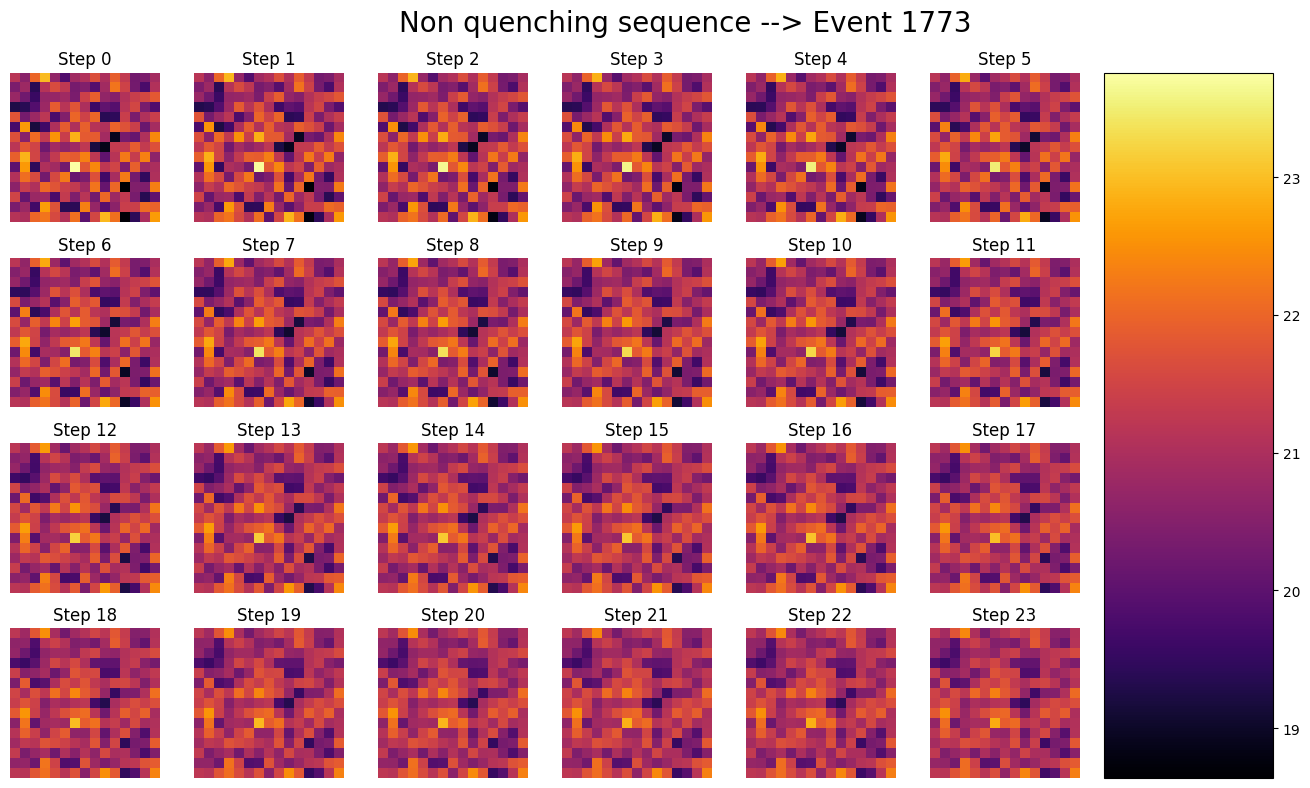

In [45]:
# -----------------Let's plot a non quenching sequence-------------------

idx = np.random.choice(np.where(labels == 0)[0])
vmin = dataPost[idx].min()
vmax = dataPost[idx].max()
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 7, figure=fig) 
axs = [fig.add_subplot(gs[i // 6, i % 6]) for i in range(24)]
for i, ax in enumerate(axs):
    im = ax.imshow(dataPost[idx, i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Step {i}")
fig.suptitle(f"Non quenching sequence --> Event {idx}", fontsize= 20)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Aggiusta il layout per fare spazio alla colorbar
plt.show()



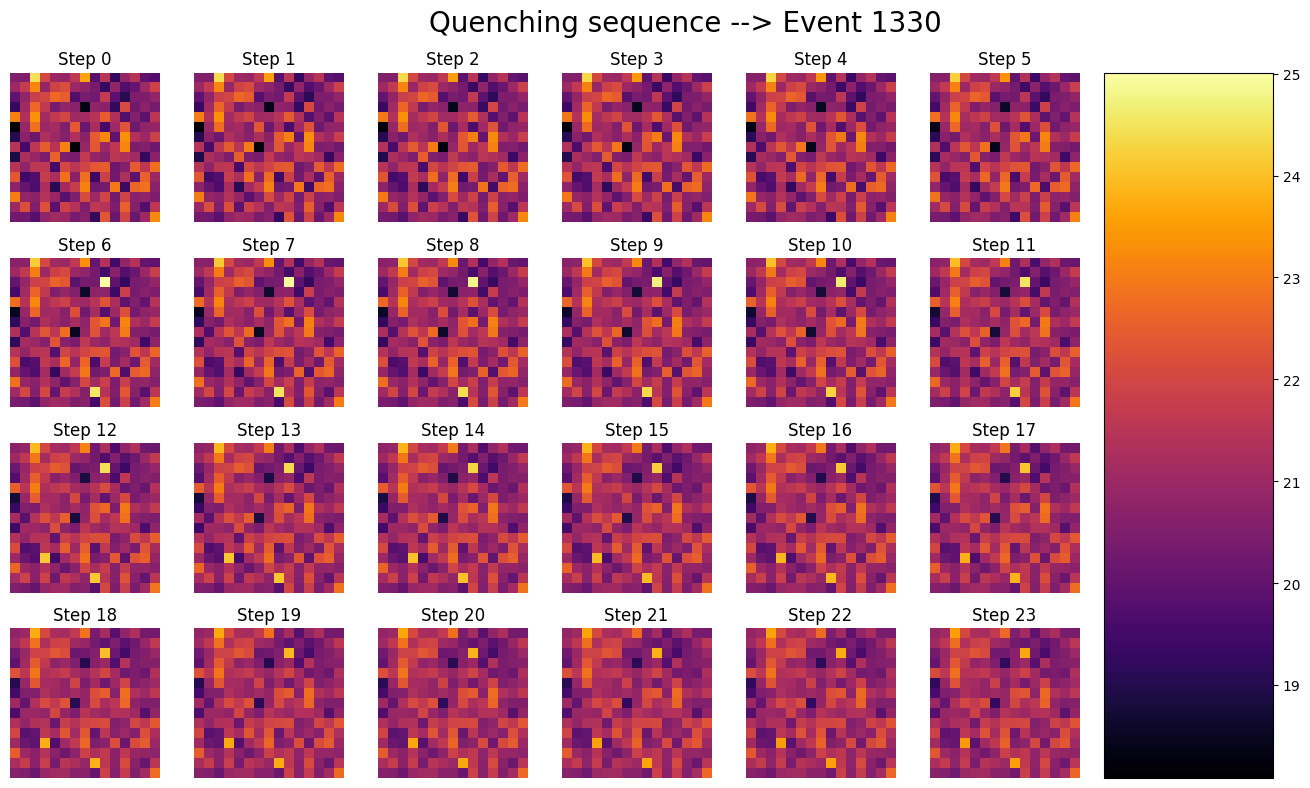

In [46]:
# -----------------Let's plot a quenching sequence-------------------

idx = np.random.choice(np.where(labels == 1)[0])
vmin = dataPost[idx].min()
vmax = dataPost[idx].max()
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 7, figure=fig) 
axs = [fig.add_subplot(gs[i // 6, i % 6]) for i in range(24)]
for i, ax in enumerate(axs):
    im = ax.imshow(dataPost[idx, i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Step {i}")
fig.suptitle(f"Quenching sequence --> Event {idx}", fontsize= 20)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Aggiusta il layout per fare spazio alla colorbar
plt.show()


# TASK 1: Identify if a sequence has quanches 

In [48]:
import dgl
import torch

# Let's create a graph for each sequence where each node is an image of the sequence
graphs = []

#let's first reshape the dataPost to have the shape (n_sequences, n_steps, 15*15)
dataPost = dataPost.reshape(dataPost.shape[0], dataPost.shape[1], -1)
print(f"Reshaped dataPost shape: {dataPost.shape}")

for i in range(dataPost.shape[0]):
    g = dgl.DGLGraph()
    g.add_nodes(dataPost.shape[1]) # Adding a node for each step of the sequence
    g.ndata['x'] = torch.tensor(dataPost[i], dtype=torch.float32) # Adding the features to each node
    # Adding edges fully connecting the nodes
    src, dst = [], []
    for j in range(dataPost.shape[1]):
        for k in range(dataPost.shape[1]):
            if j != k:
                src.append(j)
                dst.append(k)
    g.add_edges(src, dst)
    graphs.append(g)
    

#let's now normalize the features wrt the max value for each sequence
max_values = np.array([item.max() for item in dataPost])
for i in range(len(graphs)):
    graphs[i].ndata['x'] /= max_values[i]



Reshaped dataPost shape: (3000, 24, 225)


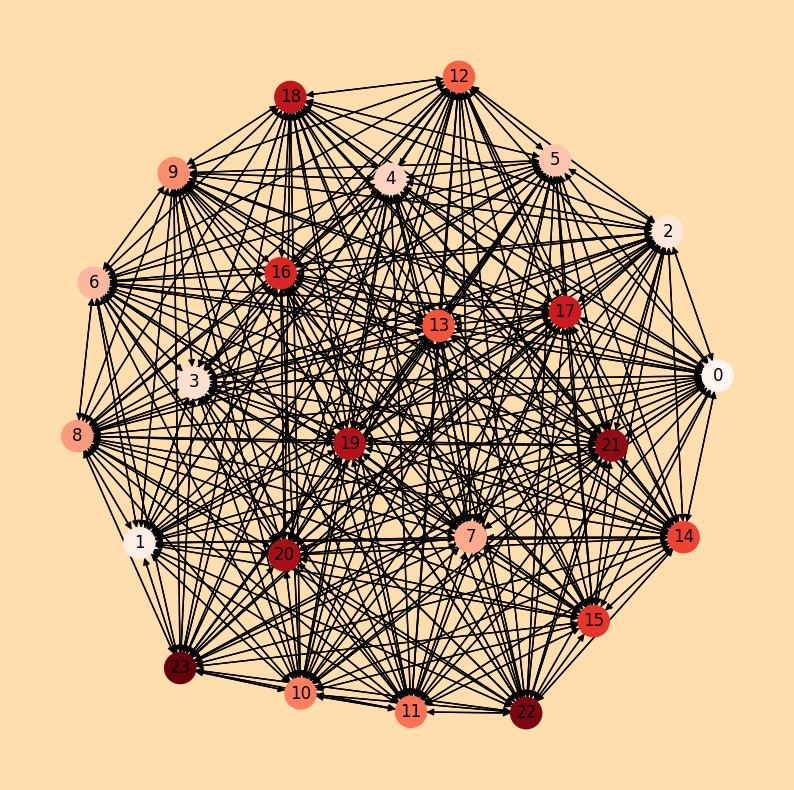

In [49]:
#Visualizing the graph of a sequence
import networkx as nx
import matplotlib.pyplot as plt

idx = np.random.choice(np.arange(len(graphs)))
G = graphs[idx].to_networkx()
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(G, pos, node_color=range(dataPost.shape[1]), cmap=plt.cm.Reds, node_size=500, with_labels=True)
ax.set_facecolor('navajowhite')
ax.axis('off')
fig.set_facecolor('navajowhite')
plt.show()


### DataLoader

In [173]:
#let's define a data loader for the dataset
from dgl.data import DGLDataset
from torch.utils.data.sampler import WeightedRandomSampler
from dgl.dataloading import GraphDataLoader
import dgl.data
import numpy as np

class GraphDataset(DGLDataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels
        super().__init__(name='my_graph_dataset')

    def process(self):
        # Here you can preprocess your graphs and labels if needed
        pass

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)


labelsTensor = [torch.tensor(label) for label in labels]

dataset = GraphDataset(graphs, labelsTensor)
print(f"Dataset length: {len(dataset)}")

#let's split the dataset in training and validation and test

n_Graphs = len(dataset)
n_train = int(n_Graphs * 0.7)
n_val = int(n_Graphs * 0.2)
n_test = n_Graphs - n_train - n_val

indices = torch.randperm(n_Graphs)
train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]


# We should create a weighted sampler to balance the classes
weights = 1 / np.bincount(labelsTensor)
weights /= weights.sum()
print(f"Class weights: {weights}")
weightsTensor = weights[labelsTensor]
print(f"Weighted labels: {weightsTensor}")

train_sampler = WeightedRandomSampler(weightsTensor[train_idx], len(train_idx), replacement=True)
val_sampler = WeightedRandomSampler(weightsTensor[val_idx], len(val_idx), replacement=True)
test_sampler = WeightedRandomSampler(weightsTensor[test_idx], len(test_idx), replacement=True)


print("\n#---------------TRAININGSET-----------------#")
print(f"Train sampler number of events: {len(train_sampler)}")
labels_train = labels[train_idx]
labels_train = labels_train[list(train_sampler)]
n_Unquench = len(labels_train[labels_train == 0])
n_Quench = len(labels_train[labels_train == 1])
print(f"Percentage of quenching events in the training set: {n_Quench / len(labels_train) * 100:.2f}%")
print(f"Percentage of non quenching events in the training set: {n_Unquench / len(labels_train) * 100:.2f}%")
print("#-----------------------------------------#\n")

print("\n#---------------VALIDATIONSET-----------------#")
print(f"Validation sampler number of events: {len(val_sampler)}")
labels_val = labels[val_idx]
labels_val = labels_val[list(val_sampler)]
n_Unquench = len(labels_val[labels_val == 0])
n_Quench = len(labels_val[labels_val == 1])
print(f"Percentage of quenching events in the validation set: {n_Quench / len(labels_val) * 100:.2f}%")
print(f"Percentage of non quenching events in the validation set: {n_Unquench / len(labels_val) * 100:.2f}%")
print("#-----------------------------------------#\n")

print("\n#---------------TESTSET-----------------#")
print(f"Test sampler number of events: {len(test_sampler)}")
labels_test = labels[test_idx]
labels_test = labels_test[list(test_sampler)]
n_Unquench = len(labels_test[labels_test == 0])
n_Quench = len(labels_test[labels_test == 1])
print(f"Percentage of quenching events in the test set: {n_Quench / len(labels_test) * 100:.2f}%")
print(f"Percentage of non quenching events in the test set: {n_Unquench / len(labels_test) * 100:.2f}%")
print("#-----------------------------------------#\n")

# Creating the data loaders
batchSize = 1

train_loader = GraphDataLoader(dataset, sampler=train_sampler, batch_size=batchSize, drop_last=False)
val_loader = GraphDataLoader(dataset, sampler=val_sampler, batch_size=batchSize, drop_last=False)
test_loader = GraphDataLoader(dataset, sampler=test_sampler, batch_size=batchSize, drop_last=False)


# Let's check the data loader
print("\n#---------------Checking the data loader-----------------#")
it = iter(train_loader)
batch = next(it)
print(f"Batch data: {batch[0]}")
print(f"Batch labels: {batch[1]}")
print("#-------------------------------------------------------#\n")


Dataset length: 3000
Class weights: [0.1 0.9]
Weighted labels: [0.1 0.1 0.1 ... 0.1 0.1 0.1]

#---------------TRAININGSET-----------------#
Train sampler number of events: 2100
Percentage of quenching events in the training set: 49.48%
Percentage of non quenching events in the training set: 50.52%
#-----------------------------------------#


#---------------VALIDATIONSET-----------------#
Validation sampler number of events: 600
Percentage of quenching events in the validation set: 49.33%
Percentage of non quenching events in the validation set: 50.67%
#-----------------------------------------#


#---------------TESTSET-----------------#
Test sampler number of events: 300
Percentage of quenching events in the test set: 49.33%
Percentage of non quenching events in the test set: 50.67%
#-----------------------------------------#


#---------------Checking the data loader-----------------#
Batch data: Graph(num_nodes=24, num_edges=552,
      ndata_schemes={'x': Scheme(shape=(225,), dtyp

### loss and models definition

In [ ]:
# Define the loss function
def loss_function(pred, label):
    return F.binary_cross_entropy_with_logits(pred, label.float().view(-1, 1))

# Define the accuracy function
def accuracy(pred, label):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).long()
    correct = (pred == label).sum().item()
    return correct / len(label)

# Training function
def train(model, optimizer, data_loader):
    model.train()
    total_loss = 0
    total_acc = 0
    for batched_graph, labels in data_loader:
        pred = model(batched_graph, batched_graph.ndata['x'])
        loss = loss_function(pred, labels)
        acc = accuracy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()
        total_acc += acc
    return total_loss / len(data_loader), total_acc / len(data_loader)

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for batched_graph, labels in data_loader:
            pred = model(batched_graph, batched_graph.ndata['x'])
            loss = loss_function(pred, labels)
            acc = accuracy(pred, labels)
            total_loss += loss.detach().item()
            total_acc += acc
    return total_loss / len(data_loader), total_acc / len(data_loader)


#### GCN

In [215]:
# Defining a first simple model
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
from dgl.nn import GATConv

class GCN(nn.Module):
    def __init__(self, in_feats, hiddenSizes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hiddenSizes[0])
        self.conv2 = dglnn.GraphConv(hiddenSizes[0], hiddenSizes[1])
        self.conv3 = dglnn.GraphConv(hiddenSizes[1], hiddenSizes[2])
        self.fc = nn.Linear(hiddenSizes[2], 1)

    def forward(self, g, x):
        h = F.relu(self.conv1(g, x))
        h = F.relu(self.conv2(g, h))
        h = F.relu(self.conv3(g, h))
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.fc(hg)
    
# Create the model with given dimensions
hiddenSizes = [64, 32, 16]
model = GCN(15*15, hiddenSizes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [216]:

# Training the model
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    

Epoch 1/30 -> Train Loss: 0.3437, Train Acc: 0.9033, Val Loss: 0.3450, Val Acc: 0.8917
Epoch 2/30 -> Train Loss: 0.2732, Train Acc: 0.9229, Val Loss: 0.3834, Val Acc: 0.8800
Epoch 3/30 -> Train Loss: 0.2908, Train Acc: 0.9152, Val Loss: 0.3105, Val Acc: 0.9067
Epoch 4/30 -> Train Loss: 0.2854, Train Acc: 0.9176, Val Loss: 0.2972, Val Acc: 0.9133
Epoch 5/30 -> Train Loss: 0.3155, Train Acc: 0.9048, Val Loss: 0.3539, Val Acc: 0.8900
Epoch 6/30 -> Train Loss: 0.2691, Train Acc: 0.9243, Val Loss: 0.3233, Val Acc: 0.9017
Epoch 7/30 -> Train Loss: 0.2964, Train Acc: 0.9129, Val Loss: 0.3144, Val Acc: 0.9050
Epoch 8/30 -> Train Loss: 0.3016, Train Acc: 0.9110, Val Loss: 0.2830, Val Acc: 0.9183
Epoch 9/30 -> Train Loss: 0.3209, Train Acc: 0.9024, Val Loss: 0.3501, Val Acc: 0.8900
Epoch 10/30 -> Train Loss: 0.3174, Train Acc: 0.9038, Val Loss: 0.3430, Val Acc: 0.8917
Epoch 11/30 -> Train Loss: 0.3067, Train Acc: 0.9086, Val Loss: 0.4188, Val Acc: 0.8617
Epoch 12/30 -> Train Loss: 0.3083, Train 

KeyboardInterrupt: 

#### GAT

In [217]:
# Defining a more complex model with GAT
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.function as fn
from dgl.nn import GATConv, GlobalAttentionPooling

# Definizione della MLP per il mapping delle node features
class MLP(nn.Module):
    def __init__(self, in_feats, hiddenSizes):
        super(MLP, self).__init__()
        layers = []
        for hidden_size in hiddenSizes:
            layers.append(nn.Linear(in_feats, hidden_size))
            layers.append(nn.ReLU())
            in_feats = hidden_size
        layers.append(nn.Linear(in_feats, 8))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Definizione della GNN con meccanismo di attenzione
class GNN(nn.Module):
    def __init__(self, in_feats, hiddenSizes, num_heads=4):
        super(GNN, self).__init__()
        self.mlp = MLP(in_feats, hiddenSizes)
        self.gat = GATConv(8, 8, num_heads=num_heads)
        self.pool = GlobalAttentionPooling(gate_nn=nn.Linear(8*num_heads, 1))
        self.fc = nn.Linear(8*num_heads, 1)

    def forward(self, g, features):
        # Step 1: MLP per mappare le node features
        updated_features = self.mlp(features)
        #print(f"Updated features shape: {updated_features.shape}")
        
        # Step 2: Message passing con meccanismo di attenzione
        g.ndata['h'] = updated_features
        attention_output = self.gat(g, updated_features)
        #print(f"Attention output shape: {attention_output.shape}")

        attention_output = attention_output.view(attention_output.size(0), -1)
        #print(f"Attention output shape after aggregation: {attention_output.shape}")
    
        # Step 3: Pooling globale per ottenere una rappresentazione del grafo
        graph_representation = self.pool(g, attention_output)
        #print(f"Graph representation shape: {graph_representation.shape}")
        #print(f"Graph representation: {graph_representation}")

        # Step 4: Classificazione
        return self.fc(graph_representation)


# Create the model with given dimensions
hiddenSizes = [64, 32, 16]
model = GNN(15*15, hiddenSizes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [218]:

# Training the model
num_epochs = 30
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    

Epoch 1/30 -> Train Loss: 0.3573, Train Acc: 0.9100, Val Loss: 0.2715, Val Acc: 0.9233
Epoch 2/30 -> Train Loss: 0.3069, Train Acc: 0.9110, Val Loss: 0.3337, Val Acc: 0.8967
Epoch 3/30 -> Train Loss: 0.3357, Train Acc: 0.8976, Val Loss: 0.3973, Val Acc: 0.8683
Epoch 4/30 -> Train Loss: 0.3147, Train Acc: 0.9071, Val Loss: 0.3112, Val Acc: 0.9100
Epoch 5/30 -> Train Loss: 0.3129, Train Acc: 0.9076, Val Loss: 0.3468, Val Acc: 0.8900
Epoch 6/30 -> Train Loss: 0.3182, Train Acc: 0.9048, Val Loss: 0.3362, Val Acc: 0.8950
Epoch 7/30 -> Train Loss: 0.3044, Train Acc: 0.9110, Val Loss: 0.3179, Val Acc: 0.9033
Epoch 8/30 -> Train Loss: 0.3263, Train Acc: 0.9019, Val Loss: 0.3386, Val Acc: 0.8950
Epoch 9/30 -> Train Loss: 0.2887, Train Acc: 0.9176, Val Loss: 0.3345, Val Acc: 0.8967
Epoch 10/30 -> Train Loss: 0.2870, Train Acc: 0.9190, Val Loss: 0.3064, Val Acc: 0.9083
Epoch 11/30 -> Train Loss: 0.3156, Train Acc: 0.9048, Val Loss: 0.3287, Val Acc: 0.8983
Epoch 12/30 -> Train Loss: 0.3059, Train 

KeyboardInterrupt: 

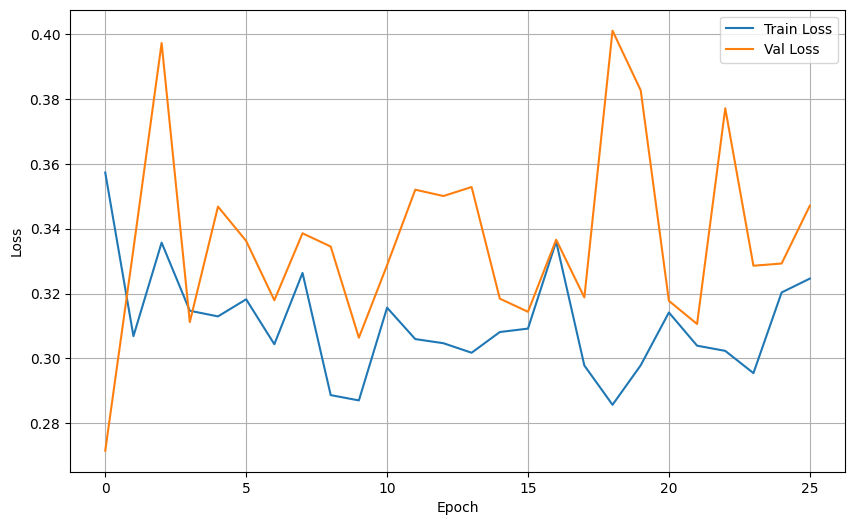

In [219]:
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
